# **Títulos IMDb: Análise da Avaliação pelo Público e Sucesso do Título**

O objetivo deste projeto prático de Big Data é, a princípio, utilizar tecnologias de Big Data. No caso, foi utilizado o PySpark para conectar com o dataset formado por milhões de registros, realizar manipulações e tratamentos de dados, assim como análises a respeito do problema proposto.

Este notebook é formado por:
- [Problema de Negócio](#problema-negocio)
- [Dados disponíveis](#dados-disponiveis)
- [Join das Tabelas](#join)
- [Tratamento dos Dados](#tratamento-dados)
- [Análise Exploratória dos Dados (EDA)](#eda)
- [Conclusão](#conclusao)

Maiores informações como o Dicionário de Variáveis podem ser consultadas aqui: https://github.com/adriana-takahagui/mba-big-data

<a name="problema-negocio"></a>
# **Problema de Negócio**



- A indústria de entretenimentos como filmes, séries, documentários, jogos, assim como qualquer negócio, precisa lidar com a satisfação ou não do seu público, principalmente para planejamento de projetos futuros e levantamento de orçamento, patrocinadores, entre outros.
- O Internet Movie Database (IMDb), um dos sites mais acessados no mundo, abriga a maior coleção digital de metadados sobre filmes, séries de TV, documentários, vídeo games, entre outras produções. Semelhante à Wikipedia, o conteúdo do site do IMDb é atualizado por usuários não remunerados. Além de aceitar informações fornecidas pelos usuários, o IMDb também permite que os usuários expressem sua opinião sobre a qualidade dos títulos por meio de avaliações, cuja escala varia de 1 (péssimo) a 10 (o melhor).
- Pensando nisso, este projeto tem como intuito auxiliar nessa dor, não só de diretores, produtores, escritores, mas também de artistas de modo geral, que é entender e talvez prever a aceitação e satisfação do público em relação a uma produção, que normalmente requer um investimento na casa dos milhares de dólares.


<a name="dados-disponiveis"></a>
# **Dados disponíveis**

- Foram utilizados dados de um conjunto de dados público localizado no site do IMDb. Os dados se referem a títulos de filmes, séries, documentários, vídeo games, entre outros, assim como dados de avaliação desses títulos.
- Segue link do IMDb: https://datasets.imdbws.com/
- Detalhes desse conjunto de dados: Ele contém muitos conjuntos de dados diferentes, que incluem dados reais. Cada conjunto de dados está contido em um arquivo comprimido (gzip) com valores separados por tabulação (TSV) no formato UTF-8. A primeira linha de cada arquivo contém cabeçalhos que descrevem o que há em cada coluna. '\N' é utilizado para indicar que um campo específico está ausente ou nulo.
- O conjunto de dados em questão é formado pelos arquivos abaixo (OBS: a lista abaixo consta apenas os arquivos utilizados neste projeto):
    - **title.basics.tsv.gz**: dados básicos dos títulos disponibilizados
    - **title.ratings.tsv.gz**: dados com avaliações por título
    - **title.akas.tsv.gz**: dados regionais de cada título
    - **title.crew.tsv.gz**: dados de diretores e escritores de cada titulo


# **Inicialização do PySpark**

Inicializando as configurações e parâmetros para utilizar o PySpark no Google Colab.

In [ ]:
# Instalar as dependências

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
# Configurar as variáveis de ambiente

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Tornar o PySpark "importável"

import findspark
findspark.init('spark-3.4.1-bin-hadoop3')

In [ ]:
# Criando sessão do Spark

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc = spark.sparkContext

# **Importação das Bibliotecas**

Importando as principais bibliotecas a serem utilizadas neste projeto

In [ ]:
# Bibliotecas do PySpark
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.sql.types import DateType, StringType, FloatType, BooleanType, IntegerType

# Bibliotecas para descomprimir os arquivos
import gzip
import shutil

# Bibilioteca do Pandas
import pandas as pd

# Outras bibliotecas para manipulação matemática e visualização dos dados
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# **Importação dos Dados**

Carregando diretamente do site do IMDb (https://datasets.imdbws.com/) os dados disponibilizados com os títulos como filmes, séries, etc. e avaliações. Para este projeto, utilizaram-se os seguintes datasets:
- title.basics.tsv.gz
- title.ratings.tsv.gz
- title.akas.tsv.gz
- title.crew.tsv.gz

In [ ]:
# Download dos arquivos a serem utilizados

!wget --quiet --show-progress https://datasets.imdbws.com/title.basics.tsv.gz
!wget --quiet --show-progress https://datasets.imdbws.com/title.ratings.tsv.gz
!wget --quiet --show-progress https://datasets.imdbws.com/title.akas.tsv.gz
!wget --quiet --show-progress https://datasets.imdbws.com/title.crew.tsv.gz

title.basics.tsv.gz 100%[===================>] 171.14M  70.7MB/s    in 2.4s    
title.ratings.tsv.g 100%[===================>]   6.54M  --.-KB/s    in 0.09s   
title.akas.tsv.gz   100%[===================>] 303.53M  85.5MB/s    in 3.5s    
title.crew.tsv.gz   100%[===================>]  65.28M  69.0MB/s    in 0.9s    


In [ ]:
# Descomprimindo o arquivo: title.basics.tsv.gz

with gzip.open('title.basics.tsv.gz', 'rb') as file_in:
    with open('title.basics.tsv', 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)
        print('Arquivo title.basics.tsv criado')

# Descomprimindo o arquivo: title.ratings.tsv.gz

with gzip.open('title.ratings.tsv.gz', 'rb') as file_in:
    with open('title.ratings.tsv', 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)
        print('Arquivo title.ratings.tsv criado')

# Descomprimindo o arquivo: title.akas.tsv.gz

with gzip.open('title.akas.tsv.gz', 'rb') as file_in:
    with open('title.akas.tsv', 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)
        print('Arquivo title.akas.tsv criado')

# Descomprimindo o arquivo: title.crew.tsv.gz

with gzip.open('title.crew.tsv.gz', 'rb') as file_in:
    with open('title.crew.tsv', 'wb') as file_out:
        shutil.copyfileobj(file_in, file_out)
        print('Arquivo title.crew.tsv criado')

Arquivo title.basics.tsv criado
Arquivo title.ratings.tsv criado
Arquivo title.akas.tsv criado
Arquivo title.crew.tsv criado


In [ ]:
# Carregando os dados de títulos básicos

with gzip.open('title.basics.tsv.gz', 'rb') as file_in:
    title_basics = spark.read.csv('title.basics.tsv', sep = r'\t', header = True)

In [ ]:
# Carregando os dados de avaliações dos títulos

with gzip.open('title.ratings.tsv.gz', 'rb') as file_in:
    title_ratings = spark.read.csv('title.ratings.tsv', sep = r'\t', header = True)

In [ ]:
# Carregando os dados de regiões dos títulos

with gzip.open('title.akas.tsv.gz', 'rb') as file_in:
    title_akas = spark.read.csv('title.akas.tsv', sep = r'\t', header = True)

In [ ]:
# Carregando os dados de diretor e escritor

with gzip.open('title.crew.tsv.gz', 'rb') as file_in:
    title_crew = spark.read.csv('title.crew.tsv', sep = r'\t', header = True)

In [ ]:
# Verificando o tamanho da tabela 'title_basics'

title_basics.count()

10270303

In [ ]:
# Verificando o schema da tabela 'title_basics'

title_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
# Verificando o tamanho da tabela 'title_ratings'

title_ratings.count()

1363972

In [ ]:
# Verificando o schema da tabela 'title_ratings'

title_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)



In [ ]:
# Verificando o tamanho da tabela 'title_akas'

title_akas.count()

37667938

In [ ]:
# Verificando o schema da tabela 'title_akas'

title_akas.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)



In [ ]:
# Verificando o tamanho da tabela 'title_crew'

title_crew.count()

10270303

In [ ]:
# Verificando o schema da tabela 'title_crew'

title_crew.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)



<a name="join"></a>
# **Join das Tabelas**

## **title_basics e title_ratings**

In [ ]:
# Realizando join entre as tabelas 'title_basics' e 'title_ratings' através da chave única 'tconst'
# Considerando apenas os títulos que possuem avaliações (inner join)

df_imdb_titles = title_basics.join(title_ratings, on = "tconst", how = 'inner')
df_imdb_titles

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string, averageRating: string, numVotes: string]

In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short",5.4,2147
1,tt0000015,short,Autour d'une cabine,Autour d'une cabine,0,1894,\N,2,"Animation,Short",6.2,1126
2,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,"Comedy,Short",5.1,31
3,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,0,1896,\N,\N,"Documentary,Short",4.2,34
4,tt0000065,short,Dessinateur: Reine Victoria,Dessinateur: Reine Victoria,0,1896,\N,\N,Short,3.2,30
5,tt0000095,short,The Mysterious Paper,Le papier protée,0,1896,\N,\N,Short,4.8,35
6,tt0000108,short,Rip Leaving Sleepy Hollow,Rip Leaving Sleepy Hollow,0,1896,\N,1,"Drama,Short",4.4,551
7,tt0000142,short,Buffalo Bill and Escort,Buffalo Bill and Escort,0,1897,\N,\N,"News,Short",4.6,30
8,tt0000145,short,En classe,En classe,0,1897,\N,\N,"Comedy,Short",3.5,14
9,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,0,1897,\N,\N,"Comedy,Short",5.0,27


In [ ]:
df_imdb_titles.count()

1363972

In [ ]:
df_imdb_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)



## **title_akas e title_ratings**

Antes de realizar o join entre as tabelas 'title_akas' e 'df_imdb_titles', vamos agrupar a tabela 'title_akas' para trazer um array de regiões em que o título está disponível.

E para diminuir o volume, primeiro vamos realizar join com a 'title_ratings' e depois realizamos o agrupamento.

In [ ]:
# Renomeando o nome da chave para 'tconst'

title_akas = title_akas.withColumnRenamed('titleId', 'tconst')

# Realizando join entre as tabelas 'title_akas' e 'title_ratings' através da chave única 'tconst'
# Considerando apenas os títulos que possuem avaliações (inner join)

title_akas_filtered = title_akas.join(title_ratings, on = "tconst", how = 'inner')

# Tratando as regiões de origem que aparecem com '\N' e substituir por 'ORIGEM'

title_akas_filtered = (title_akas_filtered
    .withColumn('region'
        , f.when(f.col('types') == 'original', 'ORIGEM')
        .otherwise(f.col('region'))
    )
)

# Filtrando apenas as linhas com regiões

title_akas_filtered = title_akas_filtered.filter(f.col('region') != '\\N')
title_akas_filtered

DataFrame[tconst: string, ordering: string, title: string, region: string, language: string, types: string, attributes: string, isOriginalTitle: string, averageRating: string, numVotes: string]

In [ ]:
title_akas_filtered.count()

4481187

In [ ]:
# Agrupando pelo chave 'tconst' e trazendo uma lista de regiões em que o título está disponível

title_akas_agg = (title_akas_filtered
    .groupBy(f.col('tconst'))
    .agg(f.collect_set(f.col('region')).alias('regions'))
)

In [ ]:
title_akas_agg.limit(10).toPandas()

,tconst,regions
0,tt0000002,"[FR, US, RU, RO, JP, DE, HU, ORIGEM]"
1,tt0000004,"[FR, RU, RO, JP, DE, HU, ORIGEM]"
2,tt0000008,"[US, UA, RU, JP, DE, HU, ORIGEM]"
3,tt0000010,"[PL, ES, UY, FI, RS, UA, CA, IT, BR, DE, FR, O..."
4,tt0000013,"[FR, PL, ES, US, RS, UA, RU, GB, XWW, ORIGEM, HU]"
5,tt0000015,"[FR, US, UA, RU, ORIGEM, HU]"
6,tt0000017,"[UA, RU, DE, ORIGEM]"
7,tt0000019,"[GB, ORIGEM]"
8,tt0000022,"[PL, ES, US, UA, RU, GB, FR, ORIGEM]"
9,tt0000027,"[ES, US, UA, RU, GB, XWW, FR, ORIGEM]"


In [ ]:
title_akas_agg.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- regions: array (nullable = false)
 |    |-- element: string (containsNull = false)



## **df_imdb_titles e title_akas_agg**

In [ ]:
# Join entre as tabelas 'df_imdb_titles' e 'title_akas_agg' através da chave 'tconst'

df_imdb_titles = df_imdb_titles.join(title_akas_agg, on = "tconst", how = 'left')
df_imdb_titles

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string, averageRating: string, numVotes: string, regions: array<string>]

In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,regions
0,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short",5.4,2147,"[US, UA, RU, JP, DE, HU, ORIGEM]"
1,tt0000015,short,Autour d'une cabine,Autour d'une cabine,0,1894,\N,2,"Animation,Short",6.2,1126,"[FR, US, UA, RU, ORIGEM, HU]"
2,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,"Comedy,Short",5.1,31,"[GB, ORIGEM]"
3,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,0,1896,\N,\N,"Documentary,Short",4.2,34,"[GB, ORIGEM, FR]"
4,tt0000065,short,Dessinateur: Reine Victoria,Dessinateur: Reine Victoria,0,1896,\N,\N,Short,3.2,30,"[ORIGEM, FR]"
5,tt0000095,short,The Mysterious Paper,Le papier protée,0,1896,\N,\N,Short,4.8,35,"[US, FR, ORIGEM]"
6,tt0000108,short,Rip Leaving Sleepy Hollow,Rip Leaving Sleepy Hollow,0,1896,\N,1,"Drama,Short",4.4,551,"[US, RU, ORIGEM]"
7,tt0000142,short,Buffalo Bill and Escort,Buffalo Bill and Escort,0,1897,\N,\N,"News,Short",4.6,30,"[US, ORIGEM]"
8,tt0000145,short,En classe,En classe,0,1897,\N,\N,"Comedy,Short",3.5,14,"[ORIGEM, FR]"
9,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,0,1897,\N,\N,"Comedy,Short",5.0,27,"[FR, HU, ORIGEM]"


In [ ]:
df_imdb_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)
 |-- regions: array (nullable = true)
 |    |-- element: string (containsNull = false)



## **df_imdb_titles e title_crew**

In [ ]:
# Join entre as tabelas 'df_imdb_titles' e 'title_crew' através da chave 'tconst'

df_imdb_titles = df_imdb_titles.join(title_crew, on = 'tconst', how = 'left')
df_imdb_titles

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string, averageRating: string, numVotes: string, regions: array<string>, directors: string, writers: string]

In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,regions,directors,writers
0,tt0000015,short,Autour d'une cabine,Autour d'une cabine,0,1894,\N,2,"Animation,Short",6.2,1126,"[FR, US, UA, RU, ORIGEM, HU]",nm0721526,\N
1,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,"Comedy,Short",5.1,31,"[GB, ORIGEM]",nm0932055,\N
2,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,0,1896,\N,\N,"Documentary,Short",4.2,34,"[GB, ORIGEM, FR]",nm0617588,\N
3,tt0000095,short,The Mysterious Paper,Le papier protée,0,1896,\N,\N,Short,4.8,35,"[US, FR, ORIGEM]",nm0617588,\N
4,tt0000145,short,En classe,En classe,0,1897,\N,\N,"Comedy,Short",3.5,14,"[ORIGEM, FR]",nm0349785,\N
5,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,0,1897,\N,\N,"Comedy,Short",5.0,27,"[FR, HU, ORIGEM]",nm0349785,\N
6,tt0000174,short,Výstavní párkar a lepic plakátù,Výstavní párkar a lepic plakátù,0,1898,\N,1,"Comedy,Short",4.6,134,"[AT, RU, XWW, ORIGEM]",nm0471818,nm0841389
7,tt0000186,short,Le cuirassé Maine,Le cuirassé Maine,0,1898,\N,\N,"Short,War",4.5,23,"[RU, ORIGEM, FR]",nm0617588,\N
8,tt0000264,short,Summoning the Spirits,Évocation spirite,0,1899,\N,1,"Fantasy,Horror,Short",5.7,465,"[US, RU, BR, FR, ORIGEM]",nm0617588,\N
9,tt0000302,short,"La fée aux choux, ou la naissance des enfants","La fée aux choux, ou la naissance des enfants",0,1900,\N,1,Short,5.2,250,"[US, IN, AU, CA, JP, DE, ORIGEM, FR]",nm0349785,\N


In [ ]:
df_imdb_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)
 |-- regions: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)



# **Análise da Qualidade dos Dados**

In [ ]:
# Existem chaves nulas?

df_imdb_titles.filter(f.col('tconst').isNull()).show()

+------+---------+------------+-------------+-------+---------+-------+--------------+------+-------------+--------+-------+---------+-------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|averageRating|numVotes|regions|directors|writers|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+-------------+--------+-------+---------+-------+
+------+---------+------------+-------------+-------+---------+-------+--------------+------+-------------+--------+-------+---------+-------+



In [ ]:
# Verificando dados inconsistentes na variável 'isAdult'

df_imdb_titles.select(f.col('isAdult')).distinct().show()

+-------+
|isAdult|
+-------+
|      0|
|      1|
|   2020|
|   2014|
|   2023|
+-------+



In [ ]:
# Verificando dados do tipo 'string' na variável 'runtimeMinutes'

df_imdb_titles.select('runtimeMinutes',
                      'isAdult',
                      f.col('runtimeMinutes').cast('int').isNotNull().alias('ValorParaChecar')
).filter(f.col('ValorParaChecar') == False).filter(f.col('runtimeMinutes').isNotNull()).show()

+--------------+-------+---------------+
|runtimeMinutes|isAdult|ValorParaChecar|
+--------------+-------+---------------+
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
|            \N|      0|          false|
+--------------+-------+---------------+
only showing top

<a name="tratamento-dados"></a>
# **Tratamentos dos Dados**

In [ ]:
# Substituindo '\N' por '0' na variável 'runtimeMinutes'
# Substituindo '\N' por 'None' nas demais variáveis

df_imdb_titles = df_imdb_titles.withColumn('titleType', f.when(f.col('titleType') == '\\N', None).otherwise(f.col('titleType')))
df_imdb_titles = df_imdb_titles.withColumn('primaryTitle', f.when(f.col('primaryTitle') == '\\N', None).otherwise(f.col('primaryTitle')))
df_imdb_titles = df_imdb_titles.withColumn('originalTitle', f.when(f.col('originalTitle') == '\\N', None).otherwise(f.col('originalTitle')))
df_imdb_titles = df_imdb_titles.withColumn('startYear', f.when(f.col('startYear') == '\\N', None).otherwise(f.col('startYear')))
df_imdb_titles = df_imdb_titles.withColumn('endYear', f.when(f.col('endYear') == '\\N', None).otherwise(f.col('endYear')))
df_imdb_titles = df_imdb_titles.withColumn('runtimeMinutes', f.when(f.col('runtimeMinutes') == '\\N', 0).otherwise(f.col('runtimeMinutes')))
df_imdb_titles = df_imdb_titles.withColumn('genres', f.when(f.col('genres') == '\\N', None).otherwise(f.col('genres')))
df_imdb_titles = df_imdb_titles.withColumn('directors', f.when(f.col('directors') == '\\N', None).otherwise(f.col('directors')))
df_imdb_titles = df_imdb_titles.withColumn('writers', f.when(f.col('writers') == '\\N', None).otherwise(f.col('writers')))

In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,regions,directors,writers
0,tt0000015,short,Autour d'une cabine,Autour d'une cabine,0,1894,None,2,"Animation,Short",6.2,1126,"[FR, US, UA, RU, ORIGEM, HU]",nm0721526,None
1,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,None,0,"Comedy,Short",5.1,31,"[GB, ORIGEM]",nm0932055,None
2,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,0,1896,None,0,"Documentary,Short",4.2,34,"[GB, ORIGEM, FR]",nm0617588,None
3,tt0000095,short,The Mysterious Paper,Le papier protée,0,1896,None,0,Short,4.8,35,"[US, FR, ORIGEM]",nm0617588,None
4,tt0000145,short,En classe,En classe,0,1897,None,0,"Comedy,Short",3.5,14,"[ORIGEM, FR]",nm0349785,None
5,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,0,1897,None,0,"Comedy,Short",5.0,27,"[FR, HU, ORIGEM]",nm0349785,None
6,tt0000174,short,Výstavní párkar a lepic plakátù,Výstavní párkar a lepic plakátù,0,1898,None,1,"Comedy,Short",4.6,134,"[AT, RU, XWW, ORIGEM]",nm0471818,nm0841389
7,tt0000186,short,Le cuirassé Maine,Le cuirassé Maine,0,1898,None,0,"Short,War",4.5,23,"[RU, ORIGEM, FR]",nm0617588,None
8,tt0000264,short,Summoning the Spirits,Évocation spirite,0,1899,None,1,"Fantasy,Horror,Short",5.7,465,"[US, RU, BR, FR, ORIGEM]",nm0617588,None
9,tt0000302,short,"La fée aux choux, ou la naissance des enfants","La fée aux choux, ou la naissance des enfants",0,1900,None,1,Short,5.2,250,"[US, IN, AU, CA, JP, DE, ORIGEM, FR]",nm0349785,None


In [ ]:
# Removendo dados inconsistentes

df_imdb_titles = df_imdb_titles.filter(f.col('isAdult').isin([2014, 2020, 2023]) == False)

In [ ]:
df_imdb_titles.count()

1363969

In [ ]:
# Verificando os tipos de dados

df_imdb_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)
 |-- regions: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)



In [ ]:
# Aplicando os tipos corretos de dados

df_imdb_titles = (df_imdb_titles
    .withColumn('isAdult', f.col('isAdult').cast(BooleanType()))
    .withColumn('startYear', f.col('startYear').cast(IntegerType()))
    .withColumn('endYear', f.col('endYear').cast(IntegerType()))
    .withColumn('runtimeMinutes', f.col('runtimeMinutes').cast(IntegerType()))
    .withColumn('averageRating', f.col('averageRating').cast(FloatType()))
    .withColumn('numVotes', f.col('numVotes').cast(IntegerType()))
)

In [ ]:
df_imdb_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: boolean (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- regions: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)



In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,regions,directors,writers
0,tt0000015,short,Autour d'une cabine,Autour d'une cabine,False,1894,NaN,2,"Animation,Short",6.2,1126,"[FR, US, UA, RU, ORIGEM, HU]",nm0721526,None
1,tt0000019,short,The Clown Barber,The Clown Barber,False,1898,NaN,0,"Comedy,Short",5.1,31,"[GB, ORIGEM]",nm0932055,None
2,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,False,1896,NaN,0,"Documentary,Short",4.2,34,"[GB, ORIGEM, FR]",nm0617588,None
3,tt0000095,short,The Mysterious Paper,Le papier protée,False,1896,NaN,0,Short,4.8,35,"[US, FR, ORIGEM]",nm0617588,None
4,tt0000145,short,En classe,En classe,False,1897,NaN,0,"Comedy,Short",3.5,14,"[ORIGEM, FR]",nm0349785,None
5,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,False,1897,NaN,0,"Comedy,Short",5.0,27,"[FR, HU, ORIGEM]",nm0349785,None
6,tt0000174,short,Výstavní párkar a lepic plakátù,Výstavní párkar a lepic plakátù,False,1898,NaN,1,"Comedy,Short",4.6,134,"[AT, RU, XWW, ORIGEM]",nm0471818,nm0841389
7,tt0000186,short,Le cuirassé Maine,Le cuirassé Maine,False,1898,NaN,0,"Short,War",4.5,23,"[RU, ORIGEM, FR]",nm0617588,None
8,tt0000264,short,Summoning the Spirits,Évocation spirite,False,1899,NaN,1,"Fantasy,Horror,Short",5.7,465,"[US, RU, BR, FR, ORIGEM]",nm0617588,None
9,tt0000302,short,"La fée aux choux, ou la naissance des enfants","La fée aux choux, ou la naissance des enfants",False,1900,NaN,1,Short,5.2,250,"[US, IN, AU, CA, JP, DE, ORIGEM, FR]",nm0349785,None


In [ ]:
# Criando a variável 'popularity' (que seria 'averageRating' mulplicado por 'numVotes')
# Criando a variável 'decade' (indicando a década do título)
# Criando um array com os gêneros, diretores e escritores (que estão como String)

df_imdb_titles = (df_imdb_titles
    .withColumn('popularity', f.col('averageRating') * f.col('numVotes'))
    .withColumn('decade', (f.floor(f.col('startYear') / 10) * 10).cast(IntegerType()))
    .withColumn('genres', f.split(f.col('genres'), ','))
    .withColumn('directors', f.split(f.col('directors'), ','))
    .withColumn('writers', f.split(f.col('writers'), ','))
)

In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,regions,directors,writers,popularity,decade
0,tt0000015,short,Autour d'une cabine,Autour d'une cabine,False,1894,NaN,2,"[Animation, Short]",6.2,1126,"[FR, US, UA, RU, ORIGEM, HU]",[nm0721526],None,6981.199707,1890
1,tt0000019,short,The Clown Barber,The Clown Barber,False,1898,NaN,0,"[Comedy, Short]",5.1,31,"[GB, ORIGEM]",[nm0932055],None,158.099991,1890
2,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,False,1896,NaN,0,"[Documentary, Short]",4.2,34,"[GB, ORIGEM, FR]",[nm0617588],None,142.799988,1890
3,tt0000095,short,The Mysterious Paper,Le papier protée,False,1896,NaN,0,[Short],4.8,35,"[US, FR, ORIGEM]",[nm0617588],None,168.000000,1890
4,tt0000145,short,En classe,En classe,False,1897,NaN,0,"[Comedy, Short]",3.5,14,"[ORIGEM, FR]",[nm0349785],None,49.000000,1890
5,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,False,1897,NaN,0,"[Comedy, Short]",5.0,27,"[FR, HU, ORIGEM]",[nm0349785],None,135.000000,1890
6,tt0000174,short,Výstavní párkar a lepic plakátù,Výstavní párkar a lepic plakátù,False,1898,NaN,1,"[Comedy, Short]",4.6,134,"[AT, RU, XWW, ORIGEM]",[nm0471818],[nm0841389],616.399963,1890
7,tt0000186,short,Le cuirassé Maine,Le cuirassé Maine,False,1898,NaN,0,"[Short, War]",4.5,23,"[RU, ORIGEM, FR]",[nm0617588],None,103.500000,1890
8,tt0000264,short,Summoning the Spirits,Évocation spirite,False,1899,NaN,1,"[Fantasy, Horror, Short]",5.7,465,"[US, RU, BR, FR, ORIGEM]",[nm0617588],None,2650.500000,1890
9,tt0000302,short,"La fée aux choux, ou la naissance des enfants","La fée aux choux, ou la naissance des enfants",False,1900,NaN,1,[Short],5.2,250,"[US, IN, AU, CA, JP, DE, ORIGEM, FR]",[nm0349785],None,1300.000000,1900


In [ ]:
df_imdb_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: boolean (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- regions: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- directors: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- writers: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- popularity: float (nullable = true)
 |-- decade: integer (nullable = true)



In [ ]:
# Criando algumas variáveis como:
# - qtyRegions: quantidade de regiões em que o título está disponível
# - qtyGenres: quantidade de gêneros em que o tíutlo foi classificado
# - qtyDirectors: quantidade de diretores que trabalharam no título
# - qtyWriters: quantidade de escritores que trabalharam no título
# Caso não tenha, trazer com zero (0)

df_imdb_titles = (df_imdb_titles
    .withColumn('qtyRegions', f.when(f.col('regions').isNull(), 0).otherwise(f.size(f.array_distinct('regions'))))
    .withColumn('qtyGenres', f.when(f.col('genres').isNull(), 0).otherwise(f.size(f.array_distinct('genres'))))
    .withColumn('qtyDirectors', f.when(f.col('directors').isNull(), 0).otherwise(f.size(f.array_distinct('directors'))))
    .withColumn('qtyWriters', f.when(f.col('writers').isNull(), 0).otherwise(f.size(f.array_distinct('writers'))))
)

In [ ]:
df_imdb_titles.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,regions,directors,writers,popularity,decade,qtyRegions,qtyGenres,qtyDirectors,qtyWriters
0,tt0000015,short,Autour d'une cabine,Autour d'une cabine,False,1894,NaN,2,"[Animation, Short]",6.2,1126,"[FR, US, UA, RU, ORIGEM, HU]",[nm0721526],None,6981.199707,1890,6,2,1,0
1,tt0000019,short,The Clown Barber,The Clown Barber,False,1898,NaN,0,"[Comedy, Short]",5.1,31,"[GB, ORIGEM]",[nm0932055],None,158.099991,1890,2,2,1,0
2,tt0000058,short,Cortège de tzar au Bois de Boulogne,Cortège de tzar au Bois de Boulogne,False,1896,NaN,0,"[Documentary, Short]",4.2,34,"[GB, ORIGEM, FR]",[nm0617588],None,142.799988,1890,3,2,1,0
3,tt0000095,short,The Mysterious Paper,Le papier protée,False,1896,NaN,0,[Short],4.8,35,"[US, FR, ORIGEM]",[nm0617588],None,168.000000,1890,3,1,1,0
4,tt0000145,short,En classe,En classe,False,1897,NaN,0,"[Comedy, Short]",3.5,14,"[ORIGEM, FR]",[nm0349785],None,49.000000,1890,2,2,1,0
5,tt0000146,short,Le cocher de fiacre endormi,Le cocher de fiacre endormi,False,1897,NaN,0,"[Comedy, Short]",5.0,27,"[FR, HU, ORIGEM]",[nm0349785],None,135.000000,1890,3,2,1,0
6,tt0000174,short,Výstavní párkar a lepic plakátù,Výstavní párkar a lepic plakátù,False,1898,NaN,1,"[Comedy, Short]",4.6,134,"[AT, RU, XWW, ORIGEM]",[nm0471818],[nm0841389],616.399963,1890,4,2,1,1
7,tt0000186,short,Le cuirassé Maine,Le cuirassé Maine,False,1898,NaN,0,"[Short, War]",4.5,23,"[RU, ORIGEM, FR]",[nm0617588],None,103.500000,1890,3,2,1,0
8,tt0000264,short,Summoning the Spirits,Évocation spirite,False,1899,NaN,1,"[Fantasy, Horror, Short]",5.7,465,"[US, RU, BR, FR, ORIGEM]",[nm0617588],None,2650.500000,1890,5,3,1,0
9,tt0000302,short,"La fée aux choux, ou la naissance des enfants","La fée aux choux, ou la naissance des enfants",False,1900,NaN,1,[Short],5.2,250,"[US, IN, AU, CA, JP, DE, ORIGEM, FR]",[nm0349785],None,1300.000000,1900,8,1,1,0


In [ ]:
# Tamanho final da tabela a ser analisada

df_imdb_titles.count()

1363969

In [ ]:
df_imdb_titles.cache()

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: boolean, startYear: int, endYear: int, runtimeMinutes: int, genres: array<string>, averageRating: float, numVotes: int, regions: array<string>, directors: array<string>, writers: array<string>, popularity: float, decade: int, qtyRegions: int, qtyGenres: int, qtyDirectors: int, qtyWriters: int]

<a name="eda"></a>
# **Análise Exploratória dos Dados (EDA)**

## Verificando algumas estatísticas

In [ ]:
df_imdb_titles.summary().toPandas()

,summary,tconst,titleType,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,averageRating,numVotes,popularity,decade,qtyRegions,qtyGenres,qtyDirectors,qtyWriters
0,count,1363969,1363969,1363969,1363969,1363735,49211,1363969,1363969,1363969,1363969,1363735,1363969,1363969,1363969,1363969
1,mean,None,None,NaN,NaN,2002.7277146953038,2007.0790676881186,39.76656067696553,6.958129992900498,1038.3655706251388,7476.419361281178,1998.3063498406948,3.0560276663179295,1.974726698334053,1.1289604089242498,2.0934134133547024
2,stddev,None,None,NaN,NaN,21.16841041447348,15.225929329631587,83.54170847507937,1.3826919080232716,17577.754512878928,140189.66455387915,21.49534830779332,5.129170517836753,0.8679064722159677,2.226466163422043,4.198826560816844
3,min,tt0000001,movie,!Next?,!Next?,1874,1933,0,1.0,5,5.0,1870,0,0,0,0
4,25%,None,None,34.0,34.0,1996,2000,0,6.2,11,79.2,1990,0,1,1,1
5,50%,None,None,318.0,318.0,2010,2012,25,7.2,26,177.09999,2010,2,2,1,1
6,75%,None,None,1984.0,1984.0,2017,2019,63,7.9,101,684.0,2010,3,3,1,3
7,max,tt9916880,videoGame,【Oshi No Ko】,þetta reddast,2023,2030,51420,10.0,2812263,2.6154046E7,2020,105,3,493,1330


**Insight**:
- Existem 1.363.969 títulos (tconst).
- Neste dataset, existem títulos lançados desde 1874 até 2023 (startYear). A maioria (75%) dos títulos são recentes (a partir de 2017).
- 75% dos títulos possuem uma duração média de até 1 hora (runtimeMinutes), e existe pelo menos 1 título com duração de 51.420 minutos (ou seja, 35,7 dias). Mas podemos notar que 25% dos títulos não possui uma duração registrada.
- 50% dos títulos possuem uma avaliação com nota média de 7,2 (uma boa avaliação) (averageRating). E a maioria (75%) recebeu uma nota média de 7,9. E existem títulos que receberam nota máxima (10.0).
- 50% dos títulos estão presentes em 2 regiões (qtyRegions) e 75% estão presentes em até 3 regiões diferentes. Existe pelo menos um título presente em 105 regiões. E 25% dos títulos não tem nenhuma região registrada.
- A maioria (75%) dos títulos possui até 3 gêneros (qtyGenres).
- A maioria (75%) dos títulos possui no máximo 1 diretor (qtyDirectors). Mas existe pelo menos um título com 493 diretores.
- A maioria (75%) dos títulos possui até 3 escritores (qtyWriters). Mas existe pelo menos um título com 1.330 escritores.



## Quantidade de títulos diferentes

Quantos títulos distintos temos neste dataset?

In [ ]:
qtyTotalTitles = df_imdb_titles.select('tconst').distinct().count()
qtyTotalTitles

1363969

## Distribuição por Avaliação ('averageRating')

Criando um dataframe em Pandas com agrupamento da quantidade de títulos e frequência para cada nota ('averageRating')

In [ ]:
df_averageRating_dist = df_imdb_titles.groupBy('averageRating').agg(f.countDistinct(f.col('tconst')).alias('qtyTitles')).sort(f.col('averageRating').asc()).toPandas()
df_averageRating_dist['frequency'] = df_averageRating_dist['qtyTitles'] / qtyTotalTitles
df_averageRating_dist.head()

,averageRating,qtyTitles,frequency
0,1.0,1100,0.000806
1,1.1,287,0.000210
2,1.2,381,0.000279
3,1.3,268,0.000196
4,1.4,410,0.000301


In [ ]:
df_averageRating_dist.shape

(91, 3)

Criando um dataframe com a média, mediana e quartil 25% e 75% das avaliações

In [ ]:
averageRatingAll = (df_imdb_titles
    .groupBy()
    .agg(
        f.round(f.mean(f.col('averageRating')), 3).alias('mean')
        , f.round(f.median(f.col('averageRating')), 3).alias('median')
        , f.round(f.percentile_approx('averageRating', 0.25, f.lit(1000000)), 2).alias('q25')
        , f.round(f.percentile_approx('averageRating', 0.75, f.lit(1000000)), 2).alias('q75')
    )
).toPandas()
averageRatingAll

,mean,median,q25,q75
0,6.958,7.2,6.2,7.9


In [ ]:
media = averageRatingAll['mean'][0]
mediana = averageRatingAll['median'][0]
quantil_25 = averageRatingAll['q25'][0]
quantil_75 = averageRatingAll['q75'][0]

print('Média:', media)
print('Mediana:', mediana)
print('Quartil 25%:', quantil_25)
print('Quartil 75%:', quantil_75)

Média: 6.958
Mediana: 7.2
Quartil 25%: 6.2
Quartil 75%: 7.9


Gerando o gráfico de distribuição das avaliações dos usuários

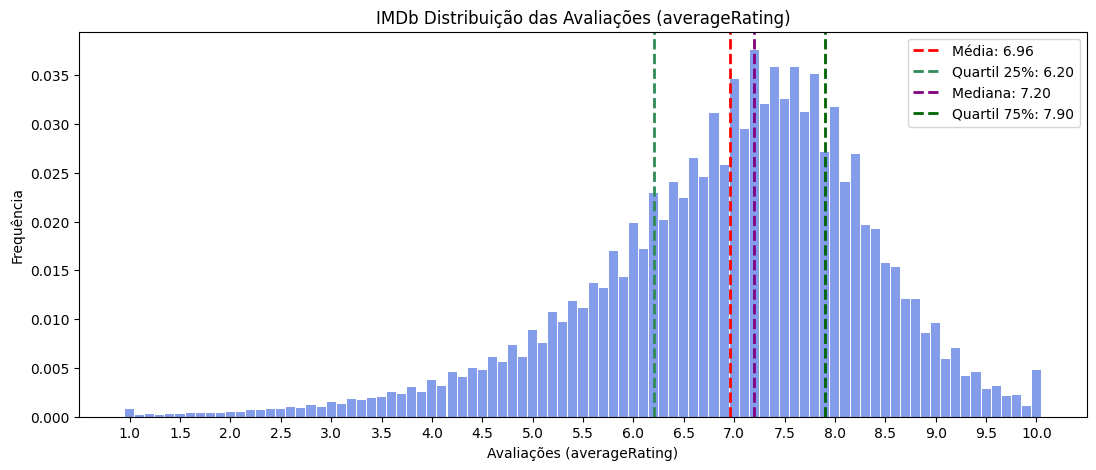

In [ ]:
plt.figure(figsize=(13,5))
plt.bar(df_averageRating_dist['averageRating'], df_averageRating_dist['frequency'], color = 'royalblue', width = 0.09, alpha = .65)
plt.axvline(media, color = 'red', linestyle = 'dashed', linewidth = 2, label = f'Média: {media:.2f}')
plt.axvline(quantil_25, color = 'seagreen', linestyle = 'dashed', linewidth = 2, label = f'Quartil 25%: {quantil_25:.2f}')
plt.axvline(mediana, color = 'purple', linestyle = 'dashed', linewidth = 2, label = f'Mediana: {mediana:.2f}')
plt.axvline(quantil_75, color = 'darkgreen', linestyle = 'dashed', linewidth = 2, label = f'Quartil 75%: {quantil_75:.2f}')
plt.xticks(np.arange(1, 10.1, 0.5))
plt.title("IMDb Distribuição das Avaliações (averageRating)")
plt.xlabel('Avaliações (averageRating)')
plt.ylabel('Frequência')
plt.legend(loc = 'upper right')
plt.show()

**Insights**:
- Podemos verificar que a distribuição apresenta o seguinte:
    - 25% dos títulos possui uma nota abaixo de 6; e
    - entre 25% a 75% dos títulos possui uma nota entre 6,2 e 7,9; e
    - os demais 25% dos títulos possui uma nota acima de 7,9

## Distribuição por década ('decade')

Criando um dataframe Pandas com agrupamento da quantidade de títulos e frequência em cada década de lançamento ou estréia do título.

In [ ]:
df_decade_dist = df_imdb_titles.groupBy('decade').agg(f.countDistinct(f.col('tconst')).alias('qtyTitles')).sort(f.col('decade').asc()).toPandas()
df_decade_dist['frequency'] = df_decade_dist['qtyTitles'] / qtyTotalTitles
df_decade_dist

,decade,qtyTitles,frequency
0,NaN,234,0.000172
1,1870.0,8,0.000006
2,1880.0,58,0.000043
3,1890.0,2394,0.001755
4,1900.0,2834,0.002078
5,1910.0,4868,0.003569
6,1920.0,6178,0.004529
7,1930.0,13175,0.009659
8,1940.0,12773,0.009365
9,1950.0,29493,0.021623


Gerando o gráfico da distribuição dos títulos por década de lançamento ou estréia

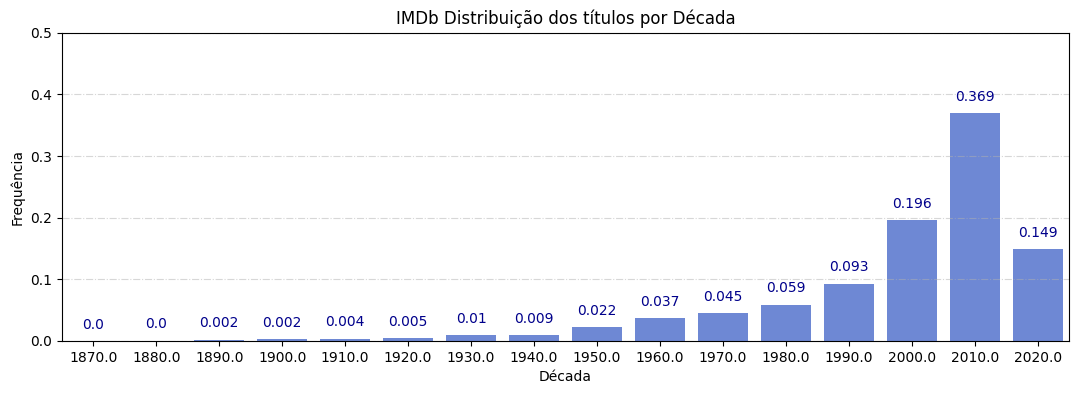

In [ ]:
plt.figure(figsize=(13,4))
ax = sns.barplot(df_decade_dist, x = 'decade', y = 'frequency', color = 'royalblue', alpha = .85)
plt.title("IMDb Distribuição dos títulos por Década")
plt.xlabel('Década')
plt.ylabel('Frequência')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
for i, v in enumerate(df_decade_dist[df_decade_dist['decade'].notnull()]['frequency']):
   ax.text(i, v + 0.02, str(round(v,3)), ha = 'center', color = 'darkblue')
plt.ylim([0, 0.5])
plt.show()

**Insights**:
- Podemos verificar que o dataset é composto por quase 71,4% dos títulos produzidos a partir dos anos 2000.

## Análise por Tipo ('titleType')

Como os títulos estão distribuídos em tipos ('titleType')? <br/>
Qual a nota média ('averageRating') de cada tipo? <br/>
E a soma de votos ('numVotes') que cada tipo recebeu? <br/>
E qual a média da popularidade ('popularity')? <br/>
E qual a média de quantidade de gêneros ('qtyGenres') em cada tipo? <br/>
E qual a média de quantidade de regiões ('qtyRegions') existem títulos disponíveis em cada tipo? <br/>
E qual a média de quantidade de diretores ('qtyDirectors') em cada tipo? <br/>
E qual a média de quantidade de escritores ('qtyWriters') em cada tipo? <br/>


In [ ]:
df_imdb_titles.groupBy('titleType').agg(
    f.countDistinct(f.col('tconst')).alias('qtyTitles')
    , (f.countDistinct(f.col('tconst')) / qtyTotalTitles).alias('percentTotal')
    , f.round(f.mean(f.col('averageRating')), 2).alias('averageRating')
    , f.sum(f.col('numVotes')).cast(t.LongType()).alias('numVotes')
    , f.round(f.mean(f.col('popularity')), 2).alias('averagePopularity')
    , f.round(f.mean(f.col('qtyGenres')), 2).alias('averageGenres')
    , f.round(f.mean(f.col('qtyRegions')), 2).alias('averageRegions')
    , f.round(f.mean(f.col('qtyDirectors')), 2).alias('averageDirectors')
    , f.round(f.mean(f.col('qtyWriters')), 2).alias('averageWriters')
).sort(f.col('qtyTitles').desc()).toPandas()

,titleType,qtyTitles,percentTotal,averageRating,numVotes,averagePopularity,averageRegions
0,tvEpisode,674427,0.494607,7.40,134082521,1591.71,1.24
1,movie,299054,0.219318,6.18,1082219005,25410.37,5.79
2,short,151863,0.111372,6.84,11347523,512.82,1.58
3,tvSeries,90384,0.066285,6.88,137032319,11972.46,4.11
4,tvMovie,51466,0.037744,6.63,12794009,1564.25,3.00
5,video,51293,0.037617,6.59,10294892,1213.32,1.73
6,tvMiniSeries,15996,0.011731,7.15,19588323,9527.74,4.45
7,videoGame,15282,0.011207,6.82,5578646,2981.10,1.72
8,tvSpecial,11591,0.008501,6.80,2722052,1703.76,1.51
9,tvShort,2206,0.001618,6.84,347628,1154.28,2.00


**Insights**:
- Podemos verificar que a maior nota média ficou com o tipo 'tvEpisode', seguido de 'tvMiniSeries'.
- Mas a maior popularidade média ficou com 'movie' e 'tvSeries'.
- Também podemos perceber que 'movie' está disponívem em várias regiões.


In [ ]:
df_type = df_imdb_titles.groupBy('titleType').agg(
    f.round(f.mean(f.col('averageRating')), 2).alias('averageRatingMean')
    , f.round(f.stddev(f.col('averageRating')), 2).alias('averageRatingStd')
).sort(f.col('titleType').asc()).toPandas()
df_type

,titleType,averageRatingMean,averageRatingStd
0,movie,6.18,1.37
1,short,6.84,1.45
2,tvEpisode,7.40,1.16
3,tvMiniSeries,7.15,1.25
4,tvMovie,6.63,1.34
5,tvSeries,6.88,1.46
6,tvShort,6.84,1.31
7,tvSpecial,6.80,1.47
8,video,6.59,1.61
9,videoGame,6.82,1.24


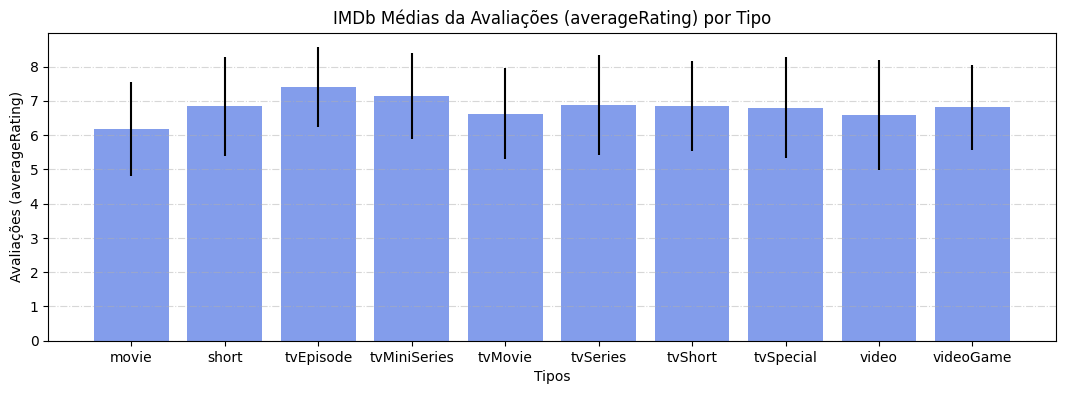

In [ ]:
plt.figure(figsize=(13,4))
plt.bar(df_type['titleType'], df_type['averageRatingMean'], yerr = df_type['averageRatingStd'], color = 'royalblue', alpha = .65)
plt.title("IMDb Médias da Avaliações (averageRating) por Tipo")
plt.xlabel('Tipos')
plt.ylabel('Avaliações (averageRating)')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
plt.show()

## Ter mais de um gênero influencia na nota média?

In [ ]:
# Criando um dataframe Pandas com estatísticas para cada quantidade de gênero

df_genres_rating = (df_imdb_titles
    .groupBy(f.col('qtyGenres'))
    .agg(
        f.round(f.percentile_approx('averageRating', 0.25, f.lit(1000000)), 2).alias('averageRating25%')
        , f.round(f.percentile_approx('averageRating', 0.5, f.lit(1000000)), 2).alias('averageRating50%')
        , f.round(f.percentile_approx('averageRating', 0.75, f.lit(1000000)), 2).alias('averageRating75%')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRatingMean')
        , f.round(f.stddev(f.col('averageRating')), 2).alias('averageRatingStd')
        , f.round(f.min(f.col('averageRating')), 2).alias('averageRatingMIN')
        , f.round(f.max(f.col('averageRating')), 2).alias('averageRatingMAX')
    )
).sort(f.col('qtyGenres').asc()).toPandas()

# Display do dataframe

df_genres_rating

,qtyGenres,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
0,0,5.5,6.6,7.6,6.45,1.57,1.0,10.0
1,1,6.1,7.1,7.8,6.87,1.45,1.0,10.0
2,2,6.1,7.1,7.9,6.91,1.39,1.0,10.0
3,3,6.4,7.3,8.0,7.11,1.28,1.0,10.0


In [ ]:
(df_imdb_titles
    .groupBy(f.col('qtyGenres'))
    .agg(
        f.count(f.col('tconst')).alias('qtyTitles')
        , (f.count(f.col('tconst')) / qtyTotalTitles).alias('percentTotal')
    )
).sort(f.col('qtyGenres').asc()).toPandas()

,qtyGenres,qtyTitles,percentTotal
0,0,20049,0.014699
1,1,471237,0.345490
2,2,395820,0.290197
3,3,476863,0.349614


**Insights**:
- Podemos verificar que existem títulos sem gênero (em torno de 1,5%) e estes possuem a menor nota média, 6,45.
- Quando analisamos títulos com pelo menos 1 gênero, os títulos com 1 e 3 gêneros possuem quase a mesma distribuição, 34,5% dos títulos, mas aqueles com 3 gêneros possui uma maior nota média, 7,11.

In [ ]:
# Criando um dataframe Pandas com estatísticas para cada quantidade de gênero e tipo do título

df_genres_type_rating = (df_imdb_titles
    .groupBy(
        f.col('qtyGenres')
        , f.col('titleType')
    )
    .agg(
        f.round(f.percentile_approx('averageRating', 0.25, f.lit(1000000)), 2).alias('averageRating25%')
        , f.round(f.percentile_approx('averageRating', 0.5, f.lit(1000000)), 2).alias('averageRating50%')
        , f.round(f.percentile_approx('averageRating', 0.75, f.lit(1000000)), 2).alias('averageRating75%')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRatingMean')
        , f.round(f.stddev(f.col('averageRating')), 2).alias('averageRatingStd')
        , f.round(f.min(f.col('averageRating')), 2).alias('averageRatingMIN')
        , f.round(f.max(f.col('averageRating')), 2).alias('averageRatingMAX')
    )
).sort(f.col('qtyGenres').asc()).toPandas()


In [ ]:
df_genres_type_rating[df_genres_type_rating['titleType'] == 'tvEpisode']

,qtyGenres,titleType,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
0,0,tvEpisode,6.5,7.4,8.2,7.28,1.51,1.0,10.0
15,1,tvEpisode,6.8,7.5,8.1,7.41,1.24,1.0,10.0
24,2,tvEpisode,6.8,7.5,8.1,7.38,1.15,1.0,10.0
29,3,tvEpisode,6.9,7.5,8.1,7.40,1.11,1.0,10.0


In [ ]:
df_genres_type_rating[df_genres_type_rating['titleType'] == 'movie']

,qtyGenres,titleType,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
6,0,movie,5.3,6.3,7.2,6.20,1.47,1.0,10.0
12,1,movie,5.4,6.4,7.2,6.28,1.42,1.0,10.0
26,2,movie,5.3,6.2,7.0,6.08,1.31,1.0,10.0
30,3,movie,5.3,6.2,6.9,6.07,1.30,1.0,10.0


In [ ]:
df_genres_type_rating[df_genres_type_rating['titleType'] == 'tvMovie']

,qtyGenres,titleType,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
1,0,tvMovie,5.8,6.8,7.8,6.75,1.56,1.0,10.0
8,1,tvMovie,6.0,6.8,7.6,6.75,1.35,1.0,10.0
23,2,tvMovie,5.7,6.6,7.3,6.52,1.25,1.0,10.0
36,3,tvMovie,5.5,6.3,7.1,6.26,1.31,1.3,9.7


In [ ]:
df_genres_type_rating[df_genres_type_rating['titleType'] == 'tvSeries']

,qtyGenres,titleType,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
7,0,tvSeries,5.8,7.0,8.0,6.72,1.67,1.2,10.0
10,1,tvSeries,6.1,7.1,7.9,6.85,1.53,1.0,10.0
19,2,tvSeries,6.2,7.1,7.9,6.88,1.43,1.0,10.0
28,3,tvSeries,6.4,7.2,7.8,7.02,1.21,1.0,10.0


In [ ]:
df_genres_type_rating[df_genres_type_rating['titleType'] == 'tvMiniSeries']

,qtyGenres,titleType,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
4,0,tvMiniSeries,6.1,7.1,7.9,6.90,1.48,1.0,9.9
16,1,tvMiniSeries,6.5,7.4,8.1,7.21,1.30,1.0,10.0
22,2,tvMiniSeries,6.5,7.3,7.9,7.12,1.21,1.0,10.0
34,3,tvMiniSeries,6.5,7.2,7.8,7.07,1.12,1.0,10.0


**Insights**:
- Analisando o gênero por tipo, podemos verificar que:
    - O tipo 'tvEpisode' possui uma nota média maior, acima de 7,2, e que possuir 1, 2 ou 3 gêneros não faz muita diferença (a média ficou em torno de 7,4)
    - Para o tipo 'movie' e 'tvMovie', a nota média ficou abaixo de 7, sendo que 'tvMovie' tende a ter uma nota média um pouco maior que 'movie'. E para ambos, ter mais de 1 gênero tende a ter uma nota média menor.
    - Agora, para o tipo 'tvSeries' e 'tvMiniSeries', a nota média ficou em torno de 7, sendo que 'tvMiniSeries' tende a ter uma nota maior que 'tvSeries' e que quanto maior a quantidade de gêneros, menor a nota com uma diferença bem pequena.

## Estar presente em várias regiões influencia na nota média?

In [ ]:
# Criando um dataframe Pandas com estatísticas para cada quantidade de regiões

df_regions_rating = (df_imdb_titles
    .groupBy(f.col('qtyRegions'))
    .agg(
        f.round(f.percentile_approx('averageRating', 0.25, f.lit(1000000)), 2).alias('averageRating25%')
        , f.round(f.percentile_approx('averageRating', 0.5, f.lit(1000000)), 2).alias('averageRating50%')
        , f.round(f.percentile_approx('averageRating', 0.75, f.lit(1000000)), 2).alias('averageRating75%')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRatingMean')
        , f.round(f.stddev(f.col('averageRating')), 2).alias('averageRatingStd')
        , f.round(f.min(f.col('averageRating')), 2).alias('averageRatingMIN')
        , f.round(f.max(f.col('averageRating')), 2).alias('averageRatingMAX')
    )
).sort(f.col('qtyRegions').asc()).toPandas()


In [ ]:
df_regions_rating.head(11)

,qtyRegions,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
0,0,6.8,7.5,8.1,7.38,1.19,1.0,10.0
1,1,6.7,7.4,8.0,7.27,1.17,1.0,10.0
2,2,5.8,6.9,7.8,6.74,1.53,1.0,10.0
3,3,5.6,6.6,7.5,6.48,1.41,1.0,10.0
4,4,5.6,6.5,7.3,6.34,1.34,1.0,10.0
5,5,5.5,6.4,7.2,6.27,1.31,1.0,10.0
6,6,5.5,6.4,7.1,6.23,1.25,1.0,9.9
7,7,6.4,7.3,8.1,7.18,1.51,1.0,10.0
8,8,5.4,6.3,7.0,6.14,1.24,1.0,9.6
9,9,5.4,6.2,6.9,6.09,1.25,1.2,9.8


In [ ]:
df_regions_qty = (df_imdb_titles
    .groupBy(f.col('qtyRegions'))
    .agg(
        f.count(f.col('tconst')).alias('qtyTitles')
        , f.round((f.count(f.col('tconst')) / qtyTotalTitles), 4).alias('percentTotal')
    )
).sort(f.col('qtyRegions').asc()).toPandas()
df_regions_qty.head(11)

,qtyRegions,qtyTitles,percentTotal
0,0,346567,0.2541
1,1,308575,0.2262
2,2,280857,0.2059
3,3,108858,0.0798
4,4,48080,0.0353
5,5,40945,0.0300
6,6,27042,0.0198
7,7,102071,0.0748
8,8,13649,0.0100
9,9,10646,0.0078


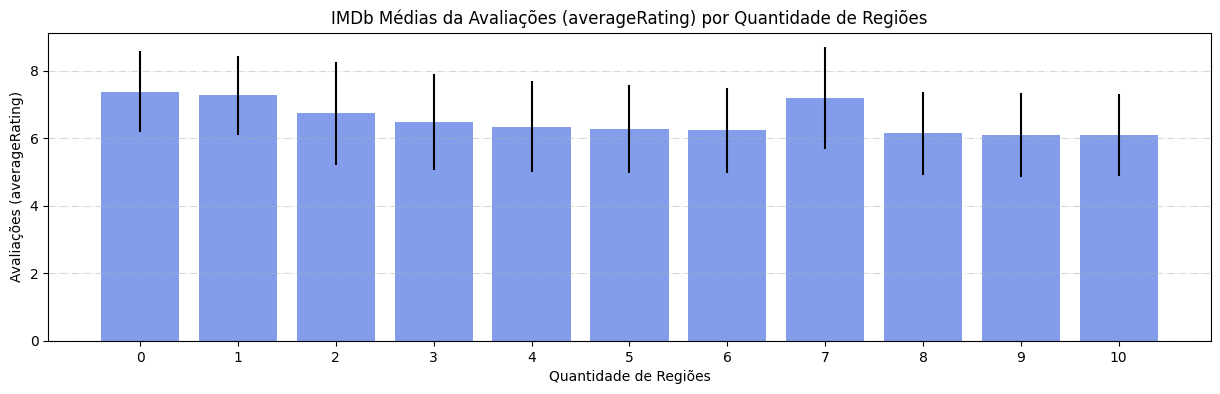

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(df_regions_rating['qtyRegions'].head(11),
        df_regions_rating['averageRatingMean'].head(11),
        yerr = df_regions_rating['averageRatingStd'].head(11),
        color = 'royalblue', alpha = .65)
plt.xticks(np.arange(0, 11, 1))
plt.title("IMDb Médias da Avaliações (averageRating) por Quantidade de Regiões")
plt.xlabel('Quantidade de Regiões')
plt.ylabel('Avaliações (averageRating)')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
plt.show()

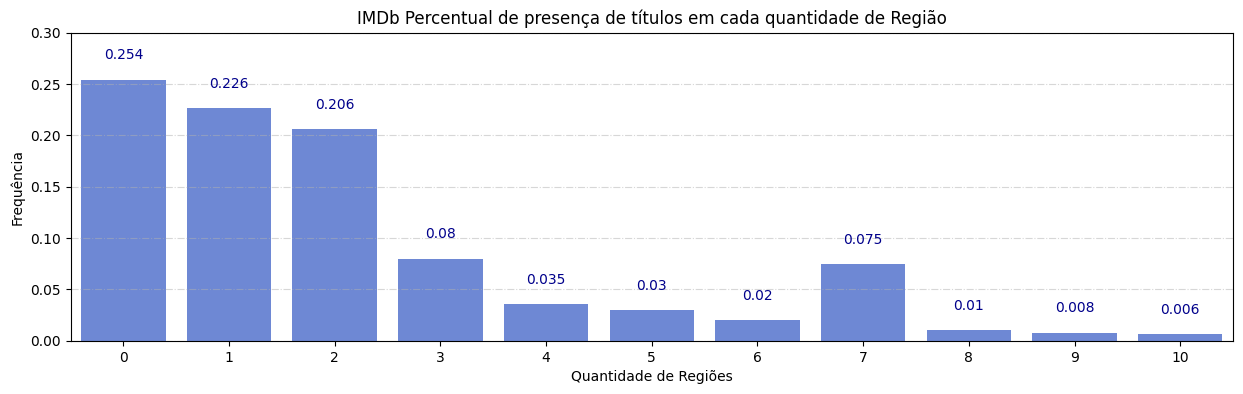

In [ ]:
plt.figure(figsize=(15,4))
ax = sns.barplot(df_regions_qty.head(11), x = 'qtyRegions', y = 'percentTotal', color = 'royalblue', alpha = .85)
plt.title("IMDb Percentual de presença de títulos em cada quantidade de Região")
plt.xlabel('Quantidade de Regiões')
plt.ylabel('Frequência')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
for i, v in enumerate(df_regions_qty['percentTotal'].head(11)):
   ax.text(i, v + 0.02, str(round(v,3)), ha = 'center', color = 'darkblue')
plt.ylim([0, 0.30])
plt.show()

**Insights**:
- Em torno de 25% dos títulos, aparentemente não tem dados de região disponível ('qtyRegions' = 0).
- Excluindo esse aparente falta de dados, a maioria (mais de 65%) dos títulos estão presentes em até 7 regiões.
- Considerando presença em até 10 regiões, podemos verificar uma pequena queda na nota média com o aumento da quantidade de regiões disponível, com exceção de 7 regiões que apresentou uma média maior que a tendência.

## Possuir mais de 1 diretor influencia na nota média?

In [ ]:
# Criando um dataframe Pandas com estatísticas para cada quantidade de diretores

df_directors_rating = (df_imdb_titles
    .groupBy(f.col('qtyDirectors'))
    .agg(
        f.round(f.percentile_approx('averageRating', 0.25, f.lit(1000000)), 2).alias('averageRating25%')
        , f.round(f.percentile_approx('averageRating', 0.5, f.lit(1000000)), 2).alias('averageRating50%')
        , f.round(f.percentile_approx('averageRating', 0.75, f.lit(1000000)), 2).alias('averageRating75%')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRatingMean')
        , f.round(f.stddev(f.col('averageRating')), 2).alias('averageRatingStd')
        , f.round(f.min(f.col('averageRating')), 2).alias('averageRatingMIN')
        , f.round(f.max(f.col('averageRating')), 2).alias('averageRatingMAX')
    )
).sort(f.col('qtyDirectors').asc()).toPandas()

In [ ]:
df_directors_rating.head(11)

,qtyDirectors,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
0,0,6.4,7.3,8.0,7.12,1.43,1.0,10.0
1,1,6.1,7.1,7.8,6.90,1.37,1.0,10.0
2,2,6.3,7.2,8.0,7.06,1.35,1.0,10.0
3,3,6.5,7.3,8.0,7.17,1.34,1.0,10.0
4,4,6.3,7.2,8.0,7.07,1.37,1.0,10.0
5,5,6.4,7.1,7.8,6.99,1.26,1.0,10.0
6,6,6.3,7.1,7.8,6.94,1.28,1.0,10.0
7,7,6.3,7.1,7.7,6.90,1.27,1.3,10.0
8,8,6.2,7.0,7.7,6.78,1.31,1.8,10.0
9,9,6.2,7.0,7.7,6.86,1.26,1.1,9.5


In [ ]:
df_directors_qty = (df_imdb_titles
    .groupBy(f.col('qtyDirectors'))
    .agg(
        f.count(f.col('tconst')).alias('qtyTitles')
        , f.round((f.count(f.col('tconst')) / qtyTotalTitles), 4).alias('percentTotal')
    )
).sort(f.col('qtyDirectors').asc()).toPandas()
df_directors_qty.head(11)

,qtyDirectors,qtyTitles,percentTotal
0,0,216571,0.1588
1,1,969566,0.7108
2,2,121692,0.0892
3,3,26837,0.0197
4,4,10188,0.0075
5,5,5089,0.0037
6,6,3136,0.0023
7,7,2134,0.0016
8,8,1540,0.0011
9,9,1117,0.0008


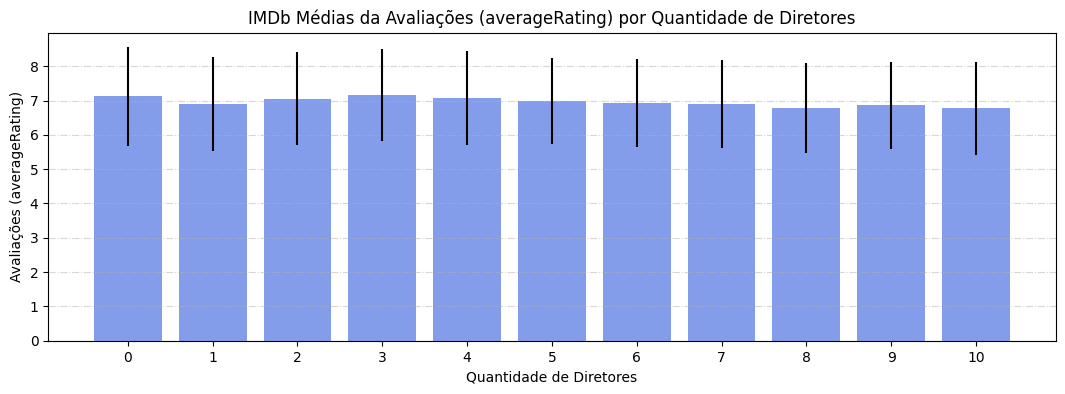

In [ ]:
plt.figure(figsize=(13,4))
plt.bar(df_directors_rating['qtyDirectors'].head(11),
        df_directors_rating['averageRatingMean'].head(11),
        yerr = df_directors_rating['averageRatingStd'].head(11),
        color = 'royalblue', alpha = .65)
plt.xticks(np.arange(0, 11, 1))
plt.title("IMDb Médias da Avaliações (averageRating) por Quantidade de Diretores")
plt.xlabel('Quantidade de Diretores')
plt.ylabel('Avaliações (averageRating)')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
plt.show()

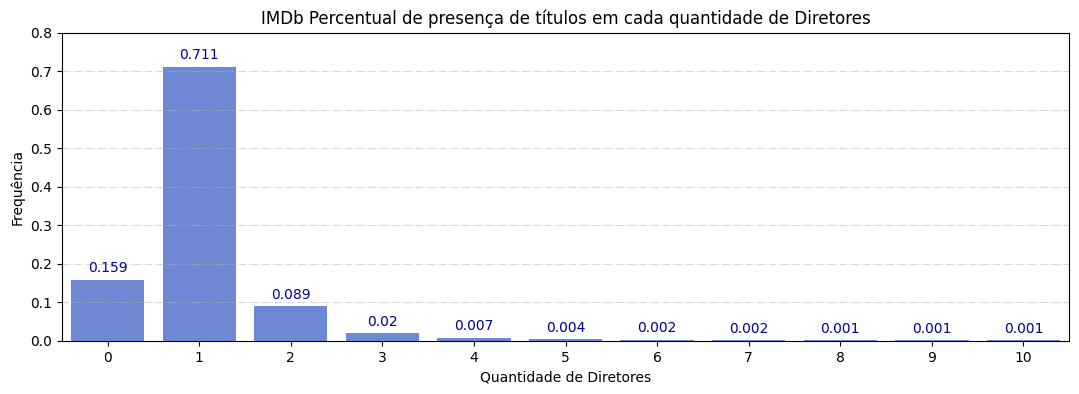

In [ ]:
plt.figure(figsize=(13,4))
ax = sns.barplot(df_directors_qty.head(11), x = 'qtyDirectors', y = 'percentTotal', color = 'royalblue', alpha = .85)
plt.title("IMDb Percentual de presença de títulos em cada quantidade de Diretores")
plt.xlabel('Quantidade de Diretores')
plt.ylabel('Frequência')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
for i, v in enumerate(df_directors_qty['percentTotal'].head(11)):
   ax.text(i, v + 0.02, str(round(v,3)), ha = 'center', color = 'darkblue')
plt.ylim([0, 0.80])
plt.show()

**Insights**:
- Verificamos que a nota média se mantém muito semelhante (em torno de 7) indenpendente da quantidade de diretores (considerando até 10 diretores, onde se concentra a maioria dos dados. 71% dos títulos possui apenas 1 diretor. 15,9% dos títulos está sem diretor)

## Possuir mais de 1 escritor influencia na nota média?

In [ ]:
# Criando um dataframe Pandas com estatísticas para cada quantidade de escritor

df_writers_rating = (df_imdb_titles
    .groupBy(f.col('qtyWriters'))
    .agg(
        f.round(f.percentile_approx('averageRating', 0.25, f.lit(1000000)), 2).alias('averageRating25%')
        , f.round(f.percentile_approx('averageRating', 0.5, f.lit(1000000)), 2).alias('averageRating50%')
        , f.round(f.percentile_approx('averageRating', 0.75, f.lit(1000000)), 2).alias('averageRating75%')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRatingMean')
        , f.round(f.stddev(f.col('averageRating')), 2).alias('averageRatingStd')
        , f.round(f.min(f.col('averageRating')), 2).alias('averageRatingMIN')
        , f.round(f.max(f.col('averageRating')), 2).alias('averageRatingMAX')
    )
).sort(f.col('qtyWriters').asc()).toPandas()

In [ ]:
df_writers_rating.head(11)

,qtyWriters,averageRating25%,averageRating50%,averageRating75%,averageRatingMean,averageRatingStd,averageRatingMIN,averageRatingMAX
0,0,6.2,7.2,8.0,7.01,1.44,1.0,10.0
1,1,6.0,7.0,7.8,6.83,1.47,1.0,10.0
2,2,6.2,7.1,7.8,6.90,1.34,1.0,10.0
3,3,6.3,7.2,7.9,7.02,1.27,1.0,10.0
4,4,6.5,7.3,7.9,7.13,1.23,1.0,10.0
5,5,6.7,7.4,8.0,7.23,1.19,1.0,10.0
6,6,6.8,7.4,8.0,7.27,1.14,1.0,10.0
7,7,6.8,7.5,8.0,7.30,1.11,1.0,10.0
8,8,6.8,7.5,8.0,7.28,1.13,1.0,10.0
9,9,6.8,7.4,8.0,7.26,1.10,1.0,10.0


In [ ]:
df_writers_qty = (df_imdb_titles
    .groupBy(f.col('qtyWriters'))
    .agg(
        f.count(f.col('tconst')).alias('qtyTitles')
        , f.round((f.count(f.col('tconst')) / qtyTotalTitles), 4).alias('percentTotal')
    )
).sort(f.col('qtyWriters').asc()).toPandas()
df_writers_qty.head(11)

,qtyWriters,qtyTitles,percentTotal
0,0,311033,0.2280
1,1,418813,0.3071
2,2,278177,0.2039
3,3,146736,0.1076
4,4,77628,0.0569
5,5,44672,0.0328
6,6,26555,0.0195
7,7,16576,0.0122
8,8,9951,0.0073
9,9,6678,0.0049


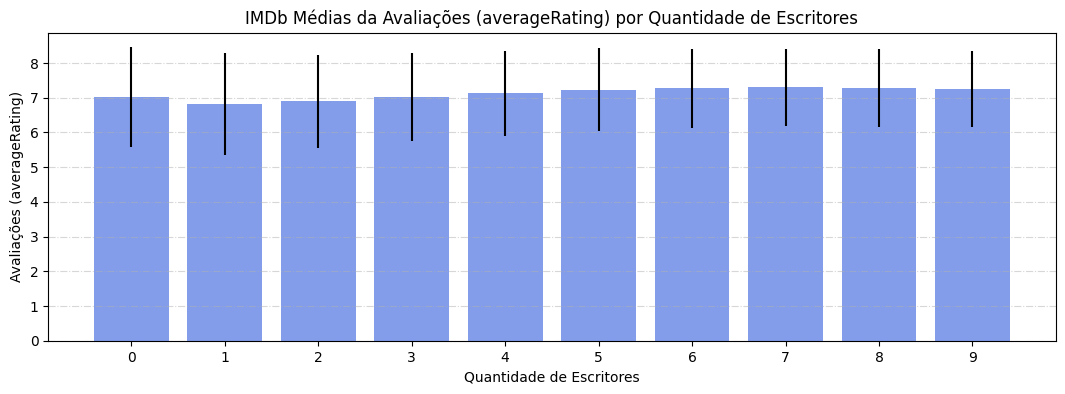

In [ ]:
plt.figure(figsize=(13,4))
plt.bar(df_writers_rating['qtyWriters'].head(10),
        df_writers_rating['averageRatingMean'].head(10),
        yerr = df_writers_rating['averageRatingStd'].head(10),
        color = 'royalblue', alpha = .65)
plt.xticks(np.arange(0, 10, 1))
plt.title("IMDb Médias da Avaliações (averageRating) por Quantidade de Escritores")
plt.xlabel('Quantidade de Escritores')
plt.ylabel('Avaliações (averageRating)')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
plt.show()

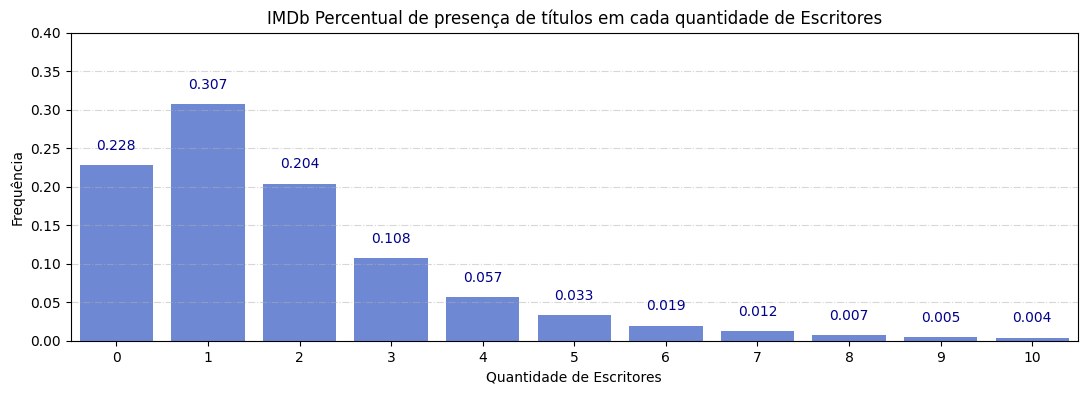

In [ ]:
plt.figure(figsize=(13,4))
ax = sns.barplot(df_writers_qty.head(11), x = 'qtyWriters', y = 'percentTotal', color = 'royalblue', alpha = .85)
plt.title("IMDb Percentual de presença de títulos em cada quantidade de Escritores")
plt.xlabel('Quantidade de Escritores')
plt.ylabel('Frequência')
plt.grid(axis = 'y', linestyle = '-.', alpha = .5)
for i, v in enumerate(df_writers_qty['percentTotal'].head(11)):
   ax.text(i, v + 0.02, str(round(v,3)), ha = 'center', color = 'darkblue')
plt.ylim([0, 0.40])
plt.show()

**Insights**:
- Considerando até 10 escritores (22,8% dos títulos não tem escritor, e 75% dos títulos possui de 1 a 10 escritores), podemos perceber uma leve diferença na nota média com o aumento da quantidade de escritores, mas a maioria dos títulos se concentra em 1 ou 2 escritores em cada título. A nota média se mantém em torno de 7.

## Distribuição dos títulos por Gênero

Como os títulos estão distribuídos em gêneros? <br/>
Qual a nota média ('averageRating') em cada gênero? <br/>
E a soma de votos ('numVotes') que cada gênero recebeu? <br/>
E qual a média da popularidade ('popularity')? <br/>
E qual a média de quantidade de regiões ('qtyRegions') existem títulos disponíveis em cada gênero? <br/>
E qual a média de quantidade de diretores ('qtyDirectors') em cada gênero? <br/>
E qual a média de quantidade de escritores ('qtyWriters') em cada gênero? <br/>

In [ ]:
# Eplodindo o gênero que está em uma lista para cada linha

df_imdb_titles_exploded = (df_imdb_titles
    .withColumn('genresExploded', f.explode(f.col('genres')))
)

In [ ]:
df_imdb_titles_exploded.limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,...,regions,directors,writers,popularity,decade,qtyRegions,qtyGenres,qtyDirectors,qtyWriters,genresExploded
0,tt0000658,short,The Puppet's Nightmare,Le cauchemar de Fantoche,False,1908,NaN,2,"[Animation, Short]",6.4,...,"[US, RU, XWW, FR]",[nm0169871],None,1766.400024,1900,4,2,1,0,Animation
1,tt0000658,short,The Puppet's Nightmare,Le cauchemar de Fantoche,False,1908,NaN,2,"[Animation, Short]",6.4,...,"[US, RU, XWW, FR]",[nm0169871],None,1766.400024,1900,4,2,1,0,Short
2,tt0001732,short,The Lighthouse Keeper,The Lighthouse Keeper,False,1911,NaN,0,"[Drama, Short]",7.1,...,[US],[nm0408436],None,120.699997,1910,1,2,1,0,Drama
3,tt0001732,short,The Lighthouse Keeper,The Lighthouse Keeper,False,1911,NaN,0,"[Drama, Short]",7.1,...,[US],[nm0408436],None,120.699997,1910,1,2,1,0,Short
4,tt0002253,short,Home Folks,Home Folks,False,1912,NaN,17,"[Drama, Short]",4.5,...,[US],[nm0000428],[nm0940488],63.000000,1910,1,2,1,1,Drama
5,tt0002253,short,Home Folks,Home Folks,False,1912,NaN,17,"[Drama, Short]",4.5,...,[US],[nm0000428],[nm0940488],63.000000,1910,1,2,1,1,Short
6,tt0002473,short,The Sands of Dee,The Sands of Dee,False,1912,NaN,17,"[Romance, Short]",6.5,...,[US],[nm0000428],[nm0455504],598.000000,1910,1,2,1,1,Romance
7,tt0002473,short,The Sands of Dee,The Sands of Dee,False,1912,NaN,17,"[Romance, Short]",6.5,...,[US],[nm0000428],[nm0455504],598.000000,1910,1,2,1,1,Short
8,tt0002588,movie,Zigomar contre Nick Carter,Zigomar contre Nick Carter,False,1912,NaN,48,"[Crime, Thriller]",6.0,...,"[NL, XWW, DE, FR]",[nm0419327],"[nm11502077, nm0419327, nm0768577]",288.000000,1910,4,2,1,3,Crime
9,tt0002588,movie,Zigomar contre Nick Carter,Zigomar contre Nick Carter,False,1912,NaN,48,"[Crime, Thriller]",6.0,...,"[NL, XWW, DE, FR]",[nm0419327],"[nm11502077, nm0419327, nm0768577]",288.000000,1910,4,2,1,3,Thriller


In [ ]:
df_imdb_titles_exploded.count()

2693466

In [ ]:
df_genres_exploded = (df_imdb_titles_exploded
    .groupBy(f.col('genresExploded'))
    .agg(
        f.countDistinct(f.col('tconst')).alias('qtyTitles')
        , (f.countDistinct(f.col('tconst')) / qtyTotalTitles).alias('percentTotal')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRating')
        , f.round(f.mean(f.col('popularity')), 2).alias('averagePopularity')
        , f.round(f.mean(f.col('qtyRegions')), 2).alias('averageRegions')
        , f.round(f.mean(f.col('qtyDirectors')), 2).alias('averageDirectors')
        , f.round(f.mean(f.col('qtyWriters')), 2).alias('averageWriters')
    )
).sort(f.col('qtyTitles').desc()).toPandas()


In [ ]:
df_genres_exploded.sort_values(by = 'averageRating', ascending = False).head(10)

,genresExploded,qtyTitles,percentTotal,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
16,History,39630,0.029055,7.35,7532.52,3.11,1.13,1.61
2,Documentary,172069,0.126153,7.25,1183.23,1.74,1.12,0.86
20,Biography,28492,0.020889,7.23,20837.80,3.85,1.10,1.46
7,Crime,146423,0.107351,7.13,14364.55,3.12,1.17,2.48
11,Mystery,66044,0.048420,7.12,17110.38,3.41,1.18,2.50
6,Adventure,152453,0.111772,7.12,17328.18,2.46,1.25,2.72
4,Animation,161845,0.118657,7.11,5431.52,1.56,1.37,2.58
21,Sport,28098,0.020600,7.10,5492.44,2.21,0.71,1.23
14,Fantasy,55933,0.041008,7.08,16079.44,3.17,1.16,2.23
9,Family,100125,0.073407,7.08,4473.02,2.15,1.18,2.45


**Insights**:
- Podemos verificar que os 3 gêneros com maior nota média são: History, Documentary e Biography.

In [ ]:
df_genres_exploded.sort_values(by = 'averagePopularity', ascending = False).head(10)

,genresExploded,qtyTitles,percentTotal,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
27,Film-Noir,883,0.000647,6.46,33899.06,15.95,1.04,2.59
18,Sci-Fi,35009,0.025667,6.69,31523.77,3.37,1.17,2.34
13,Thriller,56596,0.041494,6.42,25538.22,5.23,1.13,2.05
20,Biography,28492,0.020889,7.23,20837.80,3.85,1.10,1.46
3,Action,171611,0.125817,7.04,19010.67,2.84,1.17,2.53
6,Adventure,152453,0.111772,7.12,17328.18,2.46,1.25,2.72
11,Mystery,66044,0.048420,7.12,17110.38,3.41,1.18,2.50
14,Fantasy,55933,0.041008,7.08,16079.44,3.17,1.16,2.23
12,Horror,56999,0.041789,6.13,14718.36,3.95,1.18,1.90
7,Crime,146423,0.107351,7.13,14364.55,3.12,1.17,2.48


**Insights**:
- Podemos verificar que os 3 gêneros mais populares são: Film-Noir (apesar da maior popularidade, possui poucos títulos), Sci-Fi e Thriller (apesar de uma nota média abaixo de 7).
- Em seguida temos: Biography, Action, Adventure, Mystery e Fantasy com notas acima de 7.

In [ ]:
df_genres_types_exploded = (df_imdb_titles_exploded
    .groupBy(
        f.col('genresExploded')
        , f.col('titleType')
    )
    .agg(
        f.countDistinct(f.col('tconst')).alias('qtyTitles')
        , f.round(f.mean(f.col('averageRating')), 2).alias('averageRating')
        , f.round(f.mean(f.col('popularity')), 2).alias('averagePopularity')
        , f.round(f.mean(f.col('qtyRegions')), 2).alias('averageRegions')
        , f.round(f.mean(f.col('qtyDirectors')), 2).alias('averageDirectors')
        , f.round(f.mean(f.col('qtyWriters')), 2).alias('averageWriters')
    )
).sort(f.col('qtyTitles').desc()).toPandas()


In [ ]:
df_genres_types_exploded[df_genres_types_exploded['titleType'] == 'tvEpisode'].sort_values(by = 'averageRating', ascending = False).head(10)

,genresExploded,titleType,qtyTitles,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
74,War,tvEpisode,5235,7.77,912.46,1.54,0.98,2.12
49,Western,tvEpisode,9639,7.64,660.48,0.57,0.98,2.21
25,History,tvEpisode,22963,7.58,932.14,1.47,0.84,1.38
1,Drama,tvEpisode,225807,7.58,2868.30,1.74,1.02,2.62
15,Mystery,tvEpisode,43581,7.51,3285.26,1.42,0.95,2.49
19,Fantasy,tvEpisode,30987,7.51,3007.23,1.43,0.98,2.34
12,Romance,tvEpisode,51378,7.48,1576.46,2.56,0.97,2.47
41,Biography,tvEpisode,12520,7.48,1190.54,1.09,0.79,1.24
7,Crime,tvEpisode,103068,7.47,2507.74,1.29,0.96,2.39
9,Documentary,tvEpisode,66620,7.47,321.48,0.71,0.72,0.64


In [ ]:
df_genres_types_exploded[df_genres_types_exploded['titleType'] == 'tvEpisode'].sort_values(by = 'averagePopularity', ascending = False).head(10)

,genresExploded,titleType,qtyTitles,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
35,Horror,tvEpisode,15642,7.34,4876.66,1.25,0.91,2.26
38,Sci-Fi,tvEpisode,15129,7.29,4564.10,0.98,0.98,2.83
32,Thriller,tvEpisode,18134,7.44,4310.86,1.91,0.99,2.49
15,Mystery,tvEpisode,43581,7.51,3285.26,1.42,0.95,2.49
5,Action,tvEpisode,113195,7.46,3222.64,0.95,1.05,2.66
19,Fantasy,tvEpisode,30987,7.51,3007.23,1.43,0.98,2.34
6,Adventure,tvEpisode,112780,7.36,2877.73,0.67,1.14,2.65
1,Drama,tvEpisode,225807,7.58,2868.30,1.74,1.02,2.62
7,Crime,tvEpisode,103068,7.47,2507.74,1.29,0.96,2.39
4,Animation,tvEpisode,119190,7.29,1761.03,0.44,1.24,2.59


In [ ]:
df_genres_types_exploded[df_genres_types_exploded['titleType'] == 'movie'].sort_values(by = 'averageRating', ascending = False).head(10)

,genresExploded,titleType,qtyTitles,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
14,Documentary,movie,46504,7.23,2345.92,2.92,1.23,0.96
161,News,movie,668,7.21,3639.48,2.59,1.26,1.09
50,Biography,movie,9301,6.96,57288.46,7.79,1.16,1.57
54,History,movie,8347,6.81,26743.20,7.09,1.16,1.73
247,Talk-Show,movie,15,6.79,297.47,1.60,1.20,0.73
58,Music,movie,7430,6.75,21556.91,6.01,1.16,1.48
86,Sport,movie,3702,6.63,33189.62,6.53,1.16,1.52
221,Reality-TV,movie,62,6.55,1578.82,2.76,1.48,0.82
148,Film-Noir,movie,881,6.46,33975.48,15.98,1.04,2.60
66,War,movie,6197,6.40,29737.30,8.40,1.12,1.97


In [ ]:
df_genres_types_exploded[df_genres_types_exploded['titleType'] == 'movie'].sort_values(by = 'averagePopularity', ascending = False).head(10)

,genresExploded,titleType,qtyTitles,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
60,Sci-Fi,movie,7051,5.33,133758.36,9.70,1.17,1.94
31,Adventure,movie,18585,5.87,107814.44,10.56,1.15,2.22
75,Animation,movie,5137,6.38,89641.33,10.76,1.42,2.40
20,Action,movie,30978,5.73,80936.50,8.57,1.11,1.88
51,Fantasy,movie,8997,5.89,74860.45,8.78,1.14,1.98
43,Mystery,movie,11729,5.86,67414.55,9.43,1.10,1.94
22,Crime,movie,25985,5.99,57426.99,8.96,1.08,1.96
50,Biography,movie,9301,6.96,57288.46,7.79,1.16,1.57
24,Thriller,movie,25031,5.61,49642.85,8.23,1.08,1.75
148,Film-Noir,movie,881,6.46,33975.48,15.98,1.04,2.60


In [ ]:
df_genres_types_exploded[df_genres_types_exploded['titleType'] == 'tvSeries'].sort_values(by = 'averageRating', ascending = False).head(10)

,genresExploded,titleType,qtyTitles,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
266,Film-Noir,tvSeries,1,8.00,104.00,1.00,1.00,1.00
192,Western,tvSeries,262,7.41,16046.89,6.52,9.18,20.23
104,History,tvSeries,2380,7.40,8116.24,4.78,3.74,3.90
47,Documentary,tvSeries,9825,7.37,1938.23,2.99,3.87,2.79
144,Biography,tvSeries,962,7.33,17719.26,5.15,4.35,4.54
171,War,tvSeries,507,7.26,7364.73,4.47,3.29,4.31
139,Short,tvSeries,1050,7.15,2368.51,2.82,2.91,4.34
110,Sport,tvSeries,1954,7.13,6946.03,2.96,1.78,2.27
67,Adventure,tvSeries,6024,7.13,37811.05,9.03,4.29,8.11
101,Fantasy,tvSeries,2749,7.09,35263.45,7.67,3.54,5.42


In [ ]:
df_genres_types_exploded[df_genres_types_exploded['titleType'] == 'tvSeries'].sort_values(by = 'averagePopularity', ascending = False).head(10)

,genresExploded,titleType,qtyTitles,averageRating,averagePopularity,averageRegions,averageDirectors,averageWriters
99,Mystery,tvSeries,2873,7.07,55375.38,9.48,5.04,7.28
70,Action,tvSeries,5921,7.02,48233.22,9.42,4.54,7.19
68,Crime,tvSeries,6002,7.03,48002.60,8.38,5.46,7.80
108,Thriller,tvSeries,2116,7.03,44528.69,8.29,3.04,4.63
126,Horror,tvSeries,1537,7.08,41685.20,6.55,3.66,5.55
67,Adventure,tvSeries,6024,7.13,37811.05,9.03,4.29,8.11
117,Sci-Fi,tvSeries,1762,6.91,36914.92,6.51,3.69,5.39
101,Fantasy,tvSeries,2749,7.09,35263.45,7.67,3.54,5.42
26,Drama,tvSeries,22935,7.02,30376.99,6.61,4.11,6.38
144,Biography,tvSeries,962,7.33,17719.26,5.15,4.35,4.54


**Insights**:
- Para 'tvEpisode', os 3 gêneros com maior nota média são: War, Western e History. Mas os de maior popularidade são: Horror, Sci-Fi, Thriller, Mystery.
- Para 'movie', os 3 gêneros com maior nota média são: Documentary, News e Biography. Mas os de maior popularidade são: Sci-Fi, Adventure, Animation, Action, Fantasy, Mystery.
- Para 'tvSeries', os 3 gêneros com maior nota média são: Film-Noir (com 1 título), Western e History. Mas os de maior popularidade são: Mystery, Action, Crime, Thriller, Horror, Adventure.
- Nesses 3 tipos analisados, notamos uma diferença interessante entre os gêneros mais bem avaliados e os gêneros mais populares.

<a name="conclusao"></a>
# **Conclusão**

Podemos concluir que algumas variáveis como: 'genres' (gêneros), e 'titleType' (tipo do título) são relevantes para avaliação do título pelo usuário e consequentemente a aceitação de um título pelo público e o sucesso desse título.

No geral, notamos que os títulos são bem avaliados.

Dependendo do tipo do título, um gênero se pode se destacar mais que outro. Mas notamos uma diferença entre os gêneros quando comparamos a avaliação dada pelos usuários e a popularidade do título.

Ter mais de um gênero pode ser significativa para um determinado segmento, mas no geral apresenta uma diferença pequena.

Estar presente em várias regiões teve uma nota média menor, o que vale uma investigação mais aprofundada.

Possuir mais de 1 diretor e mais de 1 escritor não apresentou diferença significativa na nota média.

Como próximos passos, análises mais avançadas e análises das outras variáveis são pertinentes para validar as hipóteses levantadas com a exploração dos dados realizada neste projeto.

